# Clasificación (Lemma)

**Descripción :**

Dado que ya cuento con mis documentos vectorizados o embebidos, lo que procede es utilizarlos para entrenar un modelo de clasificación. Este notebook contendrá el código para entrenar un modelo de clasificación utilizando los vectores de los documentos lematizados. Tenemos vectores entrenados por nosotros mismos, vectores dados por word2vec y matriz TF-IDF.

Word2Vec form Google : https://code.google.com/archive/p/word2vec/

**Resources:**
* https://medium.com/swlh/word-embedding-word2vec-with-genism-nltk-and-t-sne-visualization-43eae8ab3e2e
* https://radimrehurek.com/gensim/models/word2vec.html

**Team:**  
* Chaparro Sicardo Tanibeth  
* Malváez Flores Axel Daniel

## Importando los vectores

In [47]:
# Librerías importantes
import numpy as np
import pandas as pd
import re
from gensim.models import word2vec, Word2Vec, KeyedVectors
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

# Models
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB

%matplotlib inline
pd.options.mode.chained_assignment = None

from utils import *

* Cargamos los datos lemmatizados

In [48]:
# Cargamos los datos
data = pd.read_csv('../Data/lemma_df.csv')

# Regex para eliminar los corchetes del string
regex = re.compile(r'[\[\]]')

# Aplicamos la regex a la columna 'stemming_description' y hacemos un split sobre la coma
data['lemma_description'] = data['lemma_description'].apply(lambda x: regex.sub('', x).split(', '))

# Creamos el corpus
corpus = data['lemma_description']
corpus = corpus.tolist()

* Creamos una etiqueta para cada documento, basandonos en su categoría

In [49]:
le = LabelEncoder()
le.fit(data['Category'])

data['label'] = le.transform(data['Category'])

### Word2Vec Propio

* Cargamos los vectores de los documentos lematizados (con nuestro word2vec propio)

In [50]:
# Load back with memory-mapping = read-only, shared across processes.
wv = KeyedVectors.load('../Data/Word2Vec-Own/word2vecSGLemma.wordvectors', mmap='r')

# Generate document vectors for each document in your corpus
size = wv.vector_size
document_vectors = np.array([document_vectorizer(doc_token, wv, vector_size=size) for doc_token in corpus])

print('Dimensión de nuestra matriz de documentos (ya vectorizados):', document_vectors.shape)

Dimensión de nuestra matriz de documentos (ya vectorizados): (50424, 300)


* Similitud Coseno

In [95]:
# Supongamos que tienes dos palabras de ejemplo
palabra1 = 'cat'
palabra2 = 'dog'

# Obtiene los vectores de palabras para ambas palabras
vector1 = wv[palabra1]
vector2 = wv[palabra2]

# Calcula la similitud de coseno entre los dos vectores
similitud_coseno = np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))

print(f"Similitud de coseno entre '{palabra1}' y '{palabra2}': {similitud_coseno:.2f}")

Similitud de coseno entre 'cat' y 'dog': 0.40


* Muestra para poder visualizar

In [74]:
# Agarramos una muestra para visualizar
X_sample, _, y_sample, _ = train_test_split(document_vectors, data['label'], test_size=0.99, random_state=42, stratify=data['label'])

* Visualización de los datos

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


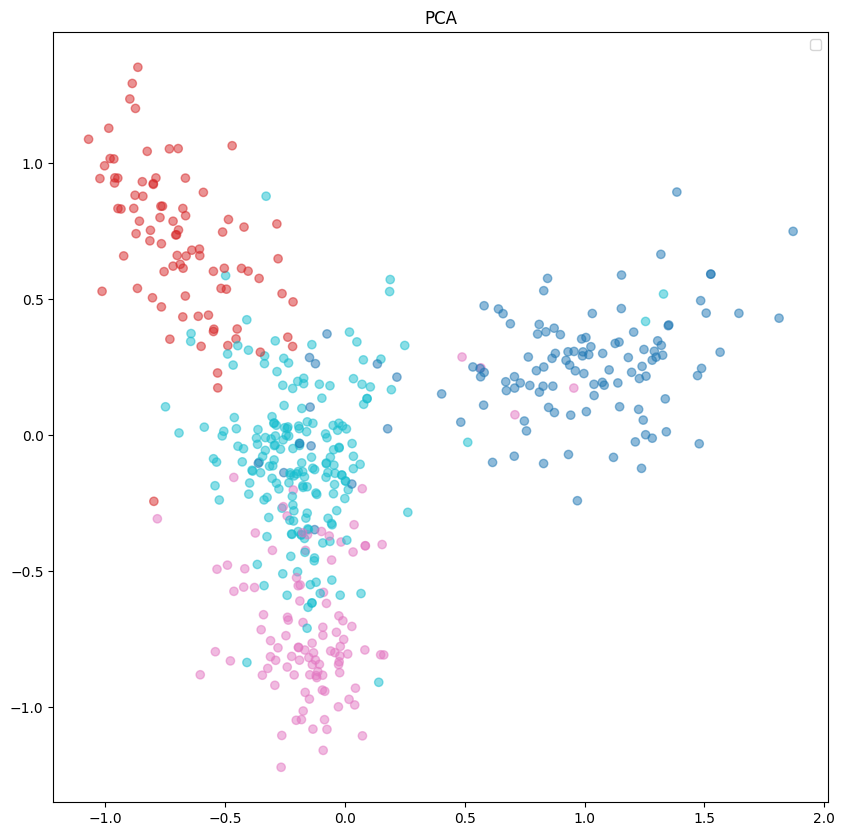

In [75]:
# Reducimos la dimensionalidad a 2 para poder visualizar
pca = PCA(n_components=2)
pca.fit(X_sample)
X_pca = pca.transform(X_sample)

# Graficamos
plt.figure(figsize=(10, 10))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_sample, cmap='tab10', alpha=0.5)
plt.title('PCA')
plt.legend()
plt.show()

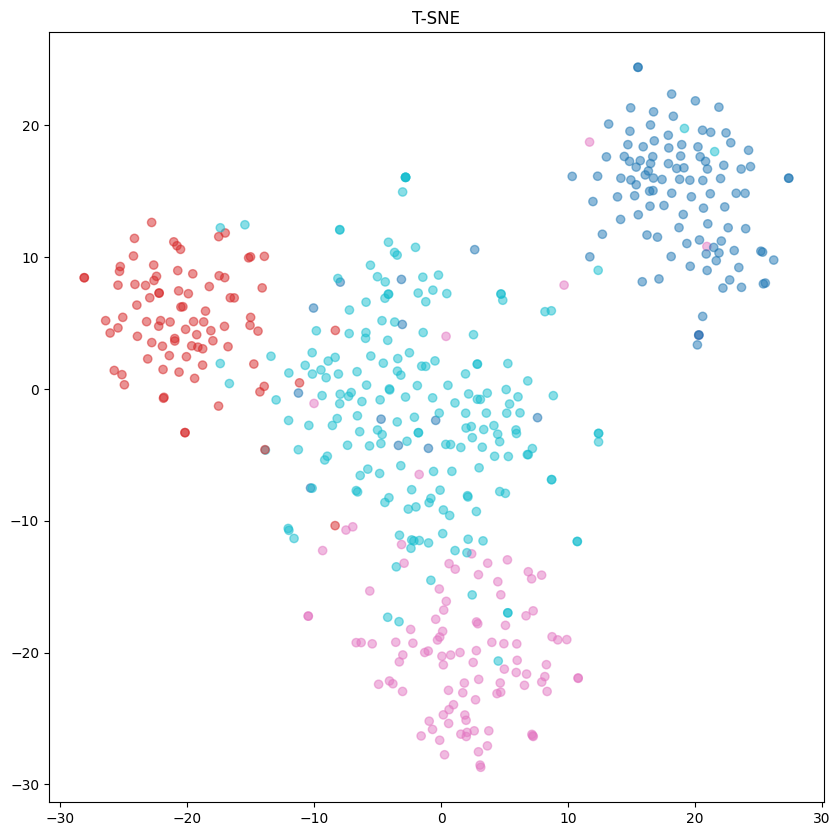

In [53]:
# Create the model and fit it
tsne = TSNE(n_components=2, random_state=0)
data_tsne = tsne.fit_transform(X_sample)

# Create the figure
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)

# Create the scatter
ax.scatter(data_tsne[:, 0], data_tsne[:, 1], alpha=0.5, c=y_sample, cmap='tab10')
plt.title('T-SNE')

# Show the plot
plt.show()

### Word2Vec de Google

* Cargamos los vectores de los documentos lematizados (con word2vec de Google)

In [54]:
# Load the pre-trained Word2Vec model
model_google = KeyedVectors.load_word2vec_format('../Data/Word2Vec-Google/GoogleNews-vectors-negative300.bin', binary=True)

document_vectors_google = np.array([document_vectorizer(doc_token, model_google) for doc_token in corpus])
print('Dimensión de nuestra matriz de documentos (ya vectorizados con Google):', document_vectors_google.shape)

Dimensión de nuestra matriz de documentos (ya vectorizados con Google): (50424, 300)


In [94]:
# Supongamos que tienes dos palabras de ejemplo
palabra1 = 'cat'
palabra2 = 'dog'

# Obtiene los vectores de palabras para ambas palabras
vector1 = model_google[palabra1]
vector2 = model_google[palabra2]

# Calcula la similitud de coseno entre los dos vectores
similitud_coseno = np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))

print(f"Similitud de coseno entre '{palabra1}' y '{palabra2}': {similitud_coseno:.2f}")

Similitud de coseno entre 'cat' y 'dog': 0.76


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


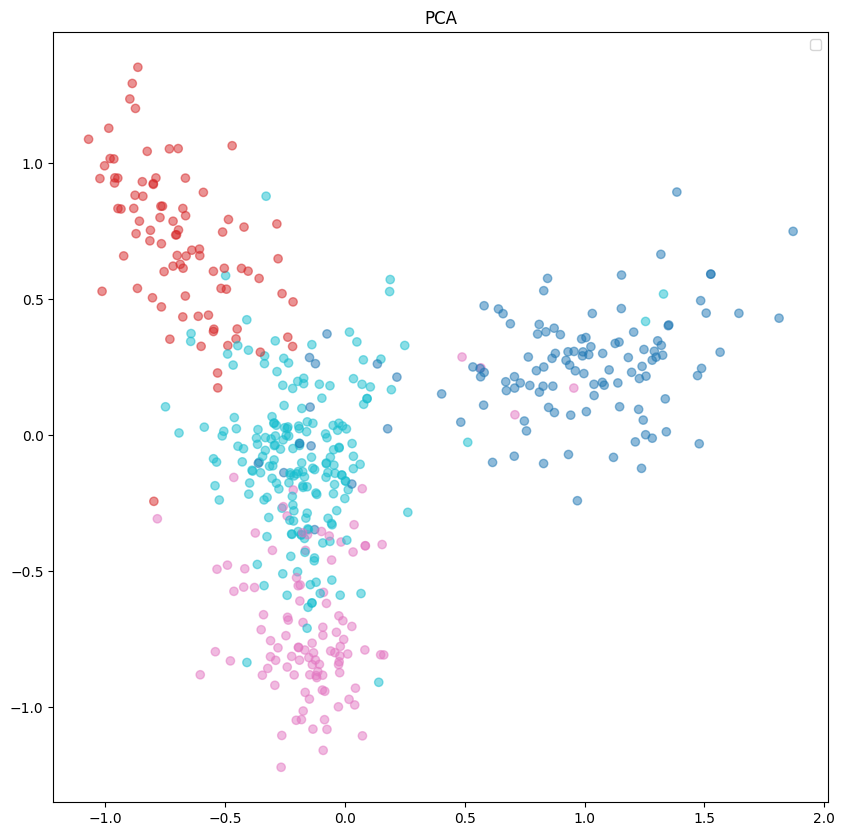

In [55]:
# Reducimos la dimensionalidad a 2 para poder visualizar
pca = PCA(n_components=2)
pca.fit(X_sample)
X_pca = pca.transform(X_sample)

# Graficamos
plt.figure(figsize=(10, 10))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_sample, cmap='tab10', alpha=0.5)
plt.title('PCA')
plt.legend()
plt.show()

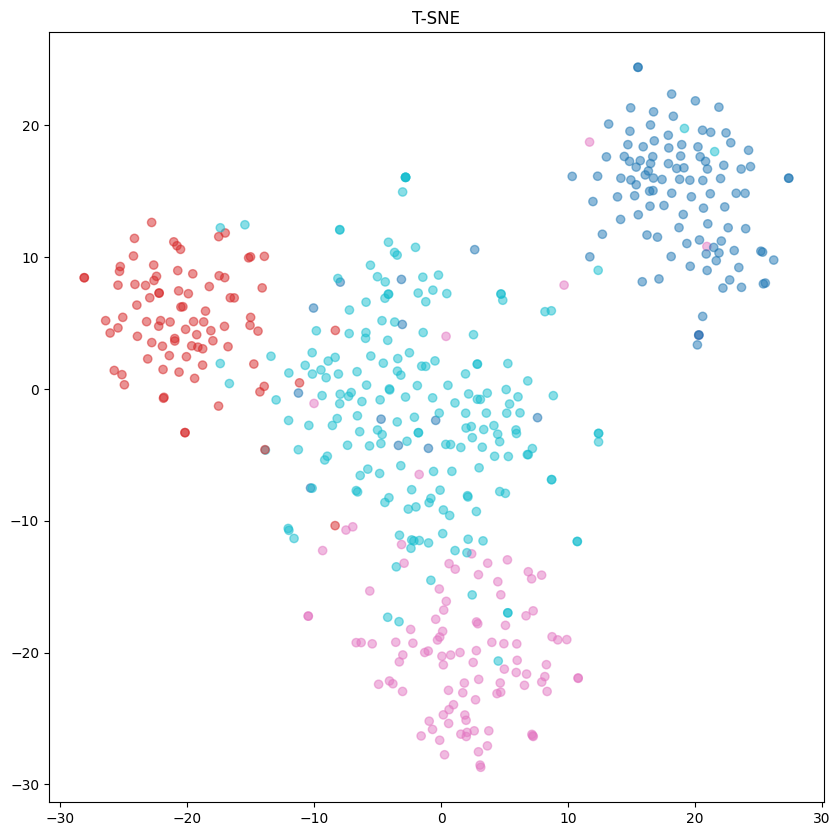

In [57]:
# Create the model and fit it
tsne = TSNE(n_components=2, random_state=0)
data_tsne = tsne.fit_transform(X_sample)

# Create the figure
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)

# Create the scatter
ax.scatter(data_tsne[:, 0], data_tsne[:, 1], alpha=0.5, c=y_sample, cmap='tab10')
plt.title('T-SNE')
    
# Show the plot
plt.show()

### Matriz TF-IDF

* Matriz TF-IDF. Debido a los problemas de memoria que se presentaron, se decidió no utilizar esta matriz para entrenar el modelo de clasificación.

In [27]:
# from sklearn.feature_extraction.text import TfidfVectorizer

# docs = []

# for doc in data['lemma_description']:
#     doc_join = ' '.join(doc)
#     docs.append(doc_join)

# # Crear un objeto TfidfVectorizer
# tfidf_vectorizer = TfidfVectorizer()

# tfidf_matrix = tfidf_vectorizer.fit_transform(docs)
# tfidf_matrix_array = tfidf_matrix.toarray()

## Clasificación

### XGBoost

#### W2V Propio

* Asignamos los datos X e y

In [28]:
X = document_vectors
y = data['label']

* Hacemos Cross Validation

In [29]:
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize parameters for XGBoost
params = {
    'objective': 'multi:softmax',  # Specify multiclass classification
    'n_estimators': 100,  # Set a large number of boosting rounds initially
    'early_stopping_rounds': 5,  # Number of rounds with no improvement to trigger early stopping
    'random_state' : 42,
}

# Initialize variables to store the models and evaluation results
models = []
f1_scores = []
precision_scores = []
recall_scores = []
accuracy_scores = []

# Perform cross-validation
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    model = XGBClassifier(params)
    model.fit(X_train, y_train,eval_set=[(X_train, y_train),(X_val, y_val)])

    # Save the trained model
    models.append(model)

    # Evaluate the model on the validation set
    y_pred = model.predict(X_val)
    f1_scores.append(f1_score(y_val, y_pred, average="macro"))
    precision_scores.append(precision_score(y_val, y_pred, average="macro"))
    recall_scores.append(recall_score(y_val, y_pred, average="macro"))
    accuracy_scores.append(accuracy_score(y_val, y_pred))

/Users/danielmalvaez/opt/anaconda3/envs/py/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `objective` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	validation_0-mlogloss:0.99288	validation_1-mlogloss:1.00229
[1]	validation_0-mlogloss:0.76890	validation_1-mlogloss:0.78411
[2]	validation_0-mlogloss:0.61929	validation_1-mlogloss:0.63784
[3]	validation_0-mlogloss:0.51115	validation_1-mlogloss:0.53455
[4]	validation_0-mlogloss:0.42979	validation_1-mlogloss:0.45698
[5]	validation_0-mlogloss:0.36794	validation_1-mlogloss:0.39842
[6]	validation_0-mlogloss:0.31946	validation_1-mlogloss:0.35146
[7]	validation_0-mlogloss:0.28057	validation_1-mlogloss:0.31562
[8]	validation_0-mlogloss:0.24988	validation_1-mlogloss:0.28745
[9]	validation_0-mlogloss:0.22425	validation_1-mlogloss:0.26388
[10]	validation_0-mlogloss:0.20318	validation_1-mlogloss:0.24517
[11]	validation_0-mlogloss:0.18464	validation_1-mlogloss:0.22883
[12]	validation_0-mlogloss:0.16873	validation_1-mlogloss:0.21463
[13]	validation_0-mlogloss:0.15532	validation_1-mlogloss:0.20349
[14]	validation_0-mlogloss:0.14368	validation_1-mlogloss:0.19322
[15]	validation_0-mlogloss:0.13301	

/Users/danielmalvaez/opt/anaconda3/envs/py/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `objective` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	validation_0-mlogloss:0.99316	validation_1-mlogloss:1.00384
[1]	validation_0-mlogloss:0.76938	validation_1-mlogloss:0.78567
[2]	validation_0-mlogloss:0.61734	validation_1-mlogloss:0.63836
[3]	validation_0-mlogloss:0.50906	validation_1-mlogloss:0.53291
[4]	validation_0-mlogloss:0.42843	validation_1-mlogloss:0.45455
[5]	validation_0-mlogloss:0.36740	validation_1-mlogloss:0.39558
[6]	validation_0-mlogloss:0.31954	validation_1-mlogloss:0.34934
[7]	validation_0-mlogloss:0.28109	validation_1-mlogloss:0.31224
[8]	validation_0-mlogloss:0.25015	validation_1-mlogloss:0.28257
[9]	validation_0-mlogloss:0.22454	validation_1-mlogloss:0.25817
[10]	validation_0-mlogloss:0.20308	validation_1-mlogloss:0.23815
[11]	validation_0-mlogloss:0.18458	validation_1-mlogloss:0.22247
[12]	validation_0-mlogloss:0.16934	validation_1-mlogloss:0.20951
[13]	validation_0-mlogloss:0.15577	validation_1-mlogloss:0.19813
[14]	validation_0-mlogloss:0.14408	validation_1-mlogloss:0.18821
[15]	validation_0-mlogloss:0.13357	

/Users/danielmalvaez/opt/anaconda3/envs/py/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `objective` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	validation_0-mlogloss:0.99366	validation_1-mlogloss:1.00416
[1]	validation_0-mlogloss:0.76881	validation_1-mlogloss:0.78614
[2]	validation_0-mlogloss:0.61822	validation_1-mlogloss:0.63974
[3]	validation_0-mlogloss:0.51046	validation_1-mlogloss:0.53484
[4]	validation_0-mlogloss:0.42886	validation_1-mlogloss:0.45590
[5]	validation_0-mlogloss:0.36597	validation_1-mlogloss:0.39424
[6]	validation_0-mlogloss:0.31727	validation_1-mlogloss:0.34705
[7]	validation_0-mlogloss:0.27797	validation_1-mlogloss:0.30965
[8]	validation_0-mlogloss:0.24720	validation_1-mlogloss:0.28074
[9]	validation_0-mlogloss:0.22141	validation_1-mlogloss:0.25699
[10]	validation_0-mlogloss:0.19964	validation_1-mlogloss:0.23710
[11]	validation_0-mlogloss:0.18229	validation_1-mlogloss:0.22132
[12]	validation_0-mlogloss:0.16626	validation_1-mlogloss:0.20798
[13]	validation_0-mlogloss:0.15254	validation_1-mlogloss:0.19644
[14]	validation_0-mlogloss:0.14053	validation_1-mlogloss:0.18596
[15]	validation_0-mlogloss:0.13035	

/Users/danielmalvaez/opt/anaconda3/envs/py/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `objective` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	validation_0-mlogloss:0.99281	validation_1-mlogloss:1.00312
[1]	validation_0-mlogloss:0.76797	validation_1-mlogloss:0.78376
[2]	validation_0-mlogloss:0.61746	validation_1-mlogloss:0.63793
[3]	validation_0-mlogloss:0.50876	validation_1-mlogloss:0.53325
[4]	validation_0-mlogloss:0.42894	validation_1-mlogloss:0.45563
[5]	validation_0-mlogloss:0.36574	validation_1-mlogloss:0.39456
[6]	validation_0-mlogloss:0.31769	validation_1-mlogloss:0.34879
[7]	validation_0-mlogloss:0.27939	validation_1-mlogloss:0.31205
[8]	validation_0-mlogloss:0.24848	validation_1-mlogloss:0.28280
[9]	validation_0-mlogloss:0.22344	validation_1-mlogloss:0.25976
[10]	validation_0-mlogloss:0.20254	validation_1-mlogloss:0.24056
[11]	validation_0-mlogloss:0.18433	validation_1-mlogloss:0.22398
[12]	validation_0-mlogloss:0.16906	validation_1-mlogloss:0.21068
[13]	validation_0-mlogloss:0.15520	validation_1-mlogloss:0.19903
[14]	validation_0-mlogloss:0.14324	validation_1-mlogloss:0.18829
[15]	validation_0-mlogloss:0.13325	

/Users/danielmalvaez/opt/anaconda3/envs/py/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `objective` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	validation_0-mlogloss:0.99359	validation_1-mlogloss:1.00112
[1]	validation_0-mlogloss:0.76851	validation_1-mlogloss:0.78129
[2]	validation_0-mlogloss:0.61713	validation_1-mlogloss:0.63465
[3]	validation_0-mlogloss:0.50948	validation_1-mlogloss:0.53081
[4]	validation_0-mlogloss:0.42786	validation_1-mlogloss:0.45252
[5]	validation_0-mlogloss:0.36516	validation_1-mlogloss:0.39247
[6]	validation_0-mlogloss:0.31635	validation_1-mlogloss:0.34710
[7]	validation_0-mlogloss:0.27745	validation_1-mlogloss:0.31079
[8]	validation_0-mlogloss:0.24640	validation_1-mlogloss:0.28299
[9]	validation_0-mlogloss:0.22139	validation_1-mlogloss:0.26007
[10]	validation_0-mlogloss:0.19981	validation_1-mlogloss:0.24056
[11]	validation_0-mlogloss:0.18149	validation_1-mlogloss:0.22508
[12]	validation_0-mlogloss:0.16674	validation_1-mlogloss:0.21266
[13]	validation_0-mlogloss:0.15340	validation_1-mlogloss:0.20086
[14]	validation_0-mlogloss:0.14171	validation_1-mlogloss:0.19088
[15]	validation_0-mlogloss:0.13170	

* Resultados

In [30]:
prom_f1 = np.mean(f1_scores)
prom_precision = np.mean(precision_scores)
prom_recall = np.mean(recall_scores)
prom_accuracy = np.mean(accuracy_scores)

print(f"F1-Score (avg): {prom_f1}")
print(f"Precision (avg): {prom_precision}")
print(f"Recall (avg): {prom_recall}")
print(f"Accuracy (avg): {prom_accuracy}")

F1-Score (avg): 0.979444374346625
Precision (avg): 0.9807611470788414
Recall (avg): 0.9781775836615367
Accuracy (avg): 0.9791567491475177


#### W2V Google

In [43]:
X = document_vectors_google
y = data['label']

In [44]:
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize parameters for XGBoost
params = {
    'objective': 'multi:softmax',  # Specify multiclass classification
    'n_estimators': 100,  # Set a large number of boosting rounds initially
    'early_stopping_rounds': 5,  # Number of rounds with no improvement to trigger early stopping
    'random_state' : 42,
}

# Initialize variables to store the models and evaluation results
models = []
f1_scores = []
precision_scores = []
recall_scores = []
accuracy_scores = []

# Perform cross-validation
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    model = XGBClassifier(params)
    model.fit(X_train, y_train,eval_set=[(X_train, y_train),(X_val, y_val)])

    # Save the trained model
    models.append(model)

    # Evaluate the model on the validation set
    y_pred = model.predict(X_val)
    f1_scores.append(f1_score(y_val, y_pred, average="macro"))
    precision_scores.append(precision_score(y_val, y_pred, average="macro"))
    recall_scores.append(recall_score(y_val, y_pred, average="macro"))
    accuracy_scores.append(accuracy_score(y_val, y_pred))

/Users/danielmalvaez/opt/anaconda3/envs/py/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `objective` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	validation_0-mlogloss:0.99390	validation_1-mlogloss:1.00273
[1]	validation_0-mlogloss:0.76966	validation_1-mlogloss:0.78499
[2]	validation_0-mlogloss:0.61757	validation_1-mlogloss:0.63878
[3]	validation_0-mlogloss:0.50929	validation_1-mlogloss:0.53497
[4]	validation_0-mlogloss:0.42782	validation_1-mlogloss:0.45745
[5]	validation_0-mlogloss:0.36496	validation_1-mlogloss:0.39696
[6]	validation_0-mlogloss:0.31707	validation_1-mlogloss:0.35203
[7]	validation_0-mlogloss:0.27941	validation_1-mlogloss:0.31695
[8]	validation_0-mlogloss:0.24869	validation_1-mlogloss:0.28880
[9]	validation_0-mlogloss:0.22290	validation_1-mlogloss:0.26518
[10]	validation_0-mlogloss:0.20119	validation_1-mlogloss:0.24604
[11]	validation_0-mlogloss:0.18374	validation_1-mlogloss:0.23048
[12]	validation_0-mlogloss:0.16917	validation_1-mlogloss:0.21771
[13]	validation_0-mlogloss:0.15610	validation_1-mlogloss:0.20698
[14]	validation_0-mlogloss:0.14426	validation_1-mlogloss:0.19701
[15]	validation_0-mlogloss:0.13394	

/Users/danielmalvaez/opt/anaconda3/envs/py/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `objective` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	validation_0-mlogloss:0.99530	validation_1-mlogloss:1.00597
[1]	validation_0-mlogloss:0.76921	validation_1-mlogloss:0.78640
[2]	validation_0-mlogloss:0.61730	validation_1-mlogloss:0.63906
[3]	validation_0-mlogloss:0.50968	validation_1-mlogloss:0.53463
[4]	validation_0-mlogloss:0.42873	validation_1-mlogloss:0.45696
[5]	validation_0-mlogloss:0.36632	validation_1-mlogloss:0.39673
[6]	validation_0-mlogloss:0.31865	validation_1-mlogloss:0.35135
[7]	validation_0-mlogloss:0.28030	validation_1-mlogloss:0.31558
[8]	validation_0-mlogloss:0.24995	validation_1-mlogloss:0.28771
[9]	validation_0-mlogloss:0.22413	validation_1-mlogloss:0.26399
[10]	validation_0-mlogloss:0.20285	validation_1-mlogloss:0.24470
[11]	validation_0-mlogloss:0.18526	validation_1-mlogloss:0.22908
[12]	validation_0-mlogloss:0.17036	validation_1-mlogloss:0.21629
[13]	validation_0-mlogloss:0.15713	validation_1-mlogloss:0.20444
[14]	validation_0-mlogloss:0.14578	validation_1-mlogloss:0.19503
[15]	validation_0-mlogloss:0.13623	

/Users/danielmalvaez/opt/anaconda3/envs/py/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `objective` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	validation_0-mlogloss:0.99538	validation_1-mlogloss:1.00587
[1]	validation_0-mlogloss:0.77014	validation_1-mlogloss:0.78612
[2]	validation_0-mlogloss:0.61856	validation_1-mlogloss:0.63844
[3]	validation_0-mlogloss:0.51009	validation_1-mlogloss:0.53304
[4]	validation_0-mlogloss:0.42881	validation_1-mlogloss:0.45444
[5]	validation_0-mlogloss:0.36685	validation_1-mlogloss:0.39550
[6]	validation_0-mlogloss:0.31923	validation_1-mlogloss:0.35070
[7]	validation_0-mlogloss:0.28089	validation_1-mlogloss:0.31543
[8]	validation_0-mlogloss:0.24971	validation_1-mlogloss:0.28622
[9]	validation_0-mlogloss:0.22389	validation_1-mlogloss:0.26271
[10]	validation_0-mlogloss:0.20269	validation_1-mlogloss:0.24322
[11]	validation_0-mlogloss:0.18451	validation_1-mlogloss:0.22702
[12]	validation_0-mlogloss:0.16951	validation_1-mlogloss:0.21369
[13]	validation_0-mlogloss:0.15653	validation_1-mlogloss:0.20276
[14]	validation_0-mlogloss:0.14573	validation_1-mlogloss:0.19298
[15]	validation_0-mlogloss:0.13551	

/Users/danielmalvaez/opt/anaconda3/envs/py/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `objective` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	validation_0-mlogloss:0.99472	validation_1-mlogloss:1.00394
[1]	validation_0-mlogloss:0.77098	validation_1-mlogloss:0.78473
[2]	validation_0-mlogloss:0.61947	validation_1-mlogloss:0.63679
[3]	validation_0-mlogloss:0.50986	validation_1-mlogloss:0.53052
[4]	validation_0-mlogloss:0.42905	validation_1-mlogloss:0.45255
[5]	validation_0-mlogloss:0.36679	validation_1-mlogloss:0.39301
[6]	validation_0-mlogloss:0.31890	validation_1-mlogloss:0.34738
[7]	validation_0-mlogloss:0.28105	validation_1-mlogloss:0.31175
[8]	validation_0-mlogloss:0.24956	validation_1-mlogloss:0.28321
[9]	validation_0-mlogloss:0.22429	validation_1-mlogloss:0.26025
[10]	validation_0-mlogloss:0.20331	validation_1-mlogloss:0.24161
[11]	validation_0-mlogloss:0.18599	validation_1-mlogloss:0.22658
[12]	validation_0-mlogloss:0.17014	validation_1-mlogloss:0.21317
[13]	validation_0-mlogloss:0.15656	validation_1-mlogloss:0.20116
[14]	validation_0-mlogloss:0.14583	validation_1-mlogloss:0.19219
[15]	validation_0-mlogloss:0.13569	

/Users/danielmalvaez/opt/anaconda3/envs/py/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `objective` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	validation_0-mlogloss:0.99402	validation_1-mlogloss:1.00523
[1]	validation_0-mlogloss:0.76808	validation_1-mlogloss:0.78748
[2]	validation_0-mlogloss:0.61729	validation_1-mlogloss:0.64236
[3]	validation_0-mlogloss:0.50833	validation_1-mlogloss:0.53882
[4]	validation_0-mlogloss:0.42664	validation_1-mlogloss:0.46139
[5]	validation_0-mlogloss:0.36468	validation_1-mlogloss:0.40292
[6]	validation_0-mlogloss:0.31668	validation_1-mlogloss:0.35803
[7]	validation_0-mlogloss:0.27860	validation_1-mlogloss:0.32269
[8]	validation_0-mlogloss:0.24756	validation_1-mlogloss:0.29439
[9]	validation_0-mlogloss:0.22198	validation_1-mlogloss:0.27118
[10]	validation_0-mlogloss:0.20131	validation_1-mlogloss:0.25270
[11]	validation_0-mlogloss:0.18368	validation_1-mlogloss:0.23683
[12]	validation_0-mlogloss:0.16857	validation_1-mlogloss:0.22414
[13]	validation_0-mlogloss:0.15567	validation_1-mlogloss:0.21303
[14]	validation_0-mlogloss:0.14448	validation_1-mlogloss:0.20348
[15]	validation_0-mlogloss:0.13426	

In [45]:
prom_f1 = np.mean(f1_scores)
prom_precision = np.mean(precision_scores)
prom_recall = np.mean(recall_scores)
prom_accuracy = np.mean(accuracy_scores)

print(f"F1-Score (avg): {prom_f1}")
print(f"Precision (avg): {prom_precision}")
print(f"Recall (avg): {prom_recall}")
print(f"Accuracy (avg): {prom_accuracy}")

F1-Score (avg): 0.9773207799825301
Precision (avg): 0.9784717368070759
Recall (avg): 0.9762191938184342
Accuracy (avg): 0.977213223498714


### Naive Bayes

#### W2V Propio

In [31]:
X = document_vectors
y = data['label']

In [32]:
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize variables to store the models and evaluation results
models = []
f1_scores = []
precision_scores = []
recall_scores = []
accuracy_scores = []

# Perform cross-validation
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    model = GaussianNB().fit(X_train, y_train)

    # Save the trained model
    models.append(model)

    # Evaluate the model on the validation set
    y_pred = model.predict(X_val)
    f1_scores.append(f1_score(y_val, y_pred, average="macro"))
    precision_scores.append(precision_score(y_val, y_pred, average="macro"))
    recall_scores.append(recall_score(y_val, y_pred, average="macro"))
    accuracy_scores.append(accuracy_score(y_val, y_pred))

* Resultados

In [33]:
prom_f1 = np.mean(f1_scores)
prom_precision = np.mean(precision_scores)
prom_recall = np.mean(recall_scores)
prom_accuracy = np.mean(accuracy_scores)

print(f"F1-Score (avg): {prom_f1}")
print(f"Precision (avg): {prom_precision}")
print(f"Recall (avg): {prom_recall}")
print(f"Accuracy (avg): {prom_accuracy}")

F1-Score (avg): 0.8714519896607053
Precision (avg): 0.8748310562497565
Recall (avg): 0.8688234349947065
Accuracy (avg): 0.8679002438023332


#### W2V Google

In [34]:
X = document_vectors_google
y = data['label']

In [35]:
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize variables to store the models and evaluation results
models = []
f1_scores = []
precision_scores = []
recall_scores = []
accuracy_scores = []

# Perform cross-validation
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    model = GaussianNB().fit(X_train, y_train)

    # Save the trained model
    models.append(model)

    # Evaluate the model on the validation set
    y_pred = model.predict(X_val)
    f1_scores.append(f1_score(y_val, y_pred, average="macro"))
    precision_scores.append(precision_score(y_val, y_pred, average="macro"))
    recall_scores.append(recall_score(y_val, y_pred, average="macro"))
    accuracy_scores.append(accuracy_score(y_val, y_pred))

* Resultados

In [36]:
prom_f1 = np.mean(f1_scores)
prom_precision = np.mean(precision_scores)
prom_recall = np.mean(recall_scores)
prom_accuracy = np.mean(accuracy_scores)

print(f"F1-Score (avg): {prom_f1}")
print(f"Precision (avg): {prom_precision}")
print(f"Recall (avg): {prom_recall}")
print(f"Accuracy (avg): {prom_accuracy}")

F1-Score (avg): 0.8457720771347272
Precision (avg): 0.8550028519088217
Recall (avg): 0.8390529219210308
Accuracy (avg): 0.8438244143345625


### SVM

#### W2V propio

In [76]:
X = document_vectors
y = data['label']

In [77]:
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize variables to store the models and evaluation results
models = []
f1_scores = []
precision_scores = []
recall_scores = []
accuracy_scores = []

# Perform cross-validation
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    model = SVC(kernel='rbf', C=7).fit(X_train, y_train)

    # Save the trained model
    models.append(model)

    # Evaluate the model on the validation set
    y_pred = model.predict(X_val)
    f1_scores.append(f1_score(y_val, y_pred, average="macro"))
    precision_scores.append(precision_score(y_val, y_pred, average="macro"))
    recall_scores.append(recall_score(y_val, y_pred, average="macro"))
    accuracy_scores.append(accuracy_score(y_val, y_pred))

In [78]:
prom_f1 = np.mean(f1_scores)
prom_precision = np.mean(precision_scores)
prom_recall = np.mean(recall_scores)
prom_accuracy = np.mean(accuracy_scores)

print(f"F1-Score (avg): {prom_f1}")
print(f"Precision (avg): {prom_precision}")
print(f"Recall (avg): {prom_recall}")
print(f"Accuracy (avg): {prom_accuracy}")

F1-Score (avg): 0.9749802284054002
Precision (avg): 0.9756306273023638
Recall (avg): 0.974364682814811
Accuracy (avg): 0.9749325595587054


#### W2V Google

In [40]:
X = document_vectors_google
y = data['label']

In [41]:
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize variables to store the models and evaluation results
models = []
f1_scores = []
precision_scores = []
recall_scores = []
accuracy_scores = []

# Perform cross-validation
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    model = SVC(kernel='rbf', C=2).fit(X_train, y_train)

    # Save the trained model
    models.append(model)

    # Evaluate the model on the validation set
    y_pred = model.predict(X_val)
    f1_scores.append(f1_score(y_val, y_pred, average="macro"))
    precision_scores.append(precision_score(y_val, y_pred, average="macro"))
    recall_scores.append(recall_score(y_val, y_pred, average="macro"))
    accuracy_scores.append(accuracy_score(y_val, y_pred))

In [42]:
prom_f1 = np.mean(f1_scores)
prom_precision = np.mean(precision_scores)
prom_recall = np.mean(recall_scores)
prom_accuracy = np.mean(accuracy_scores)

print(f"F1-Score (avg): {prom_f1}")
print(f"Precision (avg): {prom_precision}")
print(f"Recall (avg): {prom_recall}")
print(f"Accuracy (avg): {prom_accuracy}")

F1-Score (avg): 0.9650381177148061
Precision (avg): 0.9661599031713571
Recall (avg): 0.9639940108901627
Accuracy (avg): 0.9648778126897177
